# Chapter 5. Fine-tuning Large Language Models

## 5.4 Implementation of natural language inference, semantic similarity calculation, and multiple choice question answering models






### 5.4.2 Semantic Similarity Scoring

In [1]:
!pip -q install datasets transformers[ja,torch] matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

#### Obtaining Model Prediction Results

In [2]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-jsts"
text_sim_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-jsts",
    function_to_apply="none",  # Specifying a function to apply to the output
    device="cuda:0"
)

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="validation"
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
from tqdm import tqdm

# ClassLabel instance to retrieve label name information
class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # Obtain the model's prediction results
    model_prediction = text_sim_pipeline({"text": example["sentence1"], "text_pair": example["sentence2"]})

    # Store necessary information for analysis in results
    results.append(
        {
            "example_id": i,
            "pred_score": model_prediction["score"],  # The predicted score
            "true_score": example["label"],  # The true score
        }
    )

10it [00:00, 16.69it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1457it [00:34, 42.57it/s]


#### Analyzing Overall Trends

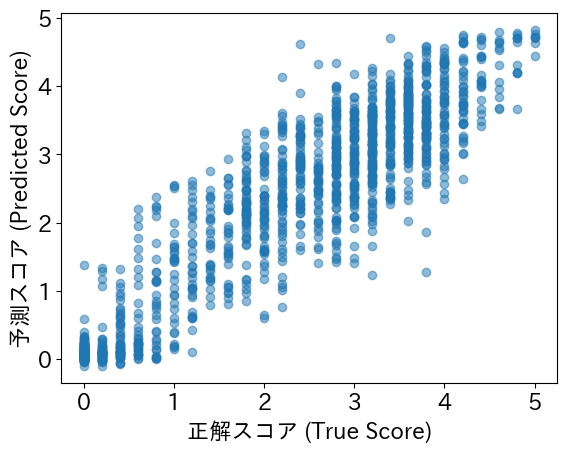

In [5]:
import japanize_matplotlib
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 16  # Set the font size

plt.scatter(
    [i["true_score"] for i in results],
    [i["pred_score"] for i in results],
    alpha=0.5
)
plt.xlabel("正解スコア (True Score)")
plt.ylabel("予測スコア (Predicted Score)")
plt.show()


#### Error Analysis

In [6]:
# Sort by the model's prediction error in descending order
sorted_results = sorted(
    results, key=lambda x: -abs(x["true_score"] - x["pred_score"])
)
# Display the top examples with high prediction probability but incorrect predictions
for top_result in sorted_results[:5]:
    sentence1 = valid_dataset[top_result["example_id"]]["sentence1"]  # Text 1
    sentence2 = valid_dataset[top_result["example_id"]]["sentence2"]  # Text 2

    print(f"テキスト１ (Text 1): {sentence1}")
    print(f"テキスト２ (Text 2): {sentence2}")

    print(f"予測スコア (Predicted Score): {top_result['pred_score']}")
    print(f"正解スコア (True Score): {top_result['true_score']}")
    # print(f"予測確率 (Prediction probability): {top_result['pred_prob']:.4f}")
    print("----------------")

テキスト１ (Text 1): 建物の中で一頭の牛が人に引かれて立っています。
テキスト２ (Text 2): 会場内で男性がホルスタインを連れています
予測スコア (Predicted Score): 1.2813432216644287
正解スコア (True Score): 3.799999952316284
----------------
テキスト１ (Text 1): ジャンボジェット機が建物の上を低空飛行しています。
テキスト２ (Text 2): ジャンボジェット機が建物の上を高空飛行しています。
予測スコア (Predicted Score): 4.614662170410156
正解スコア (True Score): 2.4000000953674316
----------------
テキスト１ (Text 1): ゲレンデのこぶでスキージャンプしています。
テキスト２ (Text 2): 雪上でモーグルを楽しむ水色のウェアを着た女性。
予測スコア (Predicted Score): 1.2380545139312744
正解スコア (True Score): 3.200000047683716
----------------
テキスト１ (Text 1): 猫がぬいぐるみを抱いて寝ています。
テキスト２ (Text 2): ぬいぐるみの横で黒猫が寝ています。
予測スコア (Predicted Score): 4.13502311706543
正解スコア (True Score): 2.200000047683716
----------------
テキスト１ (Text 1): 真っ白なトイレと洗面台が備え付けられたバスルームの写真です。
テキスト２ (Text 2): 全体を白に基調にしたユニットバスの写真です。
予測スコア (Predicted Score): 1.8714594841003418
正解スコア (True Score): 3.799999952316284
----------------
